In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image

In [2]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [3]:
infd = open('vezone.ld', 'rb')

bufsize = 1820 * 525 * 30
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)

print(data.shape)

(14668725,)


In [73]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 1820, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

(955500,)
uint8 (525, 1820) (525, 1820)


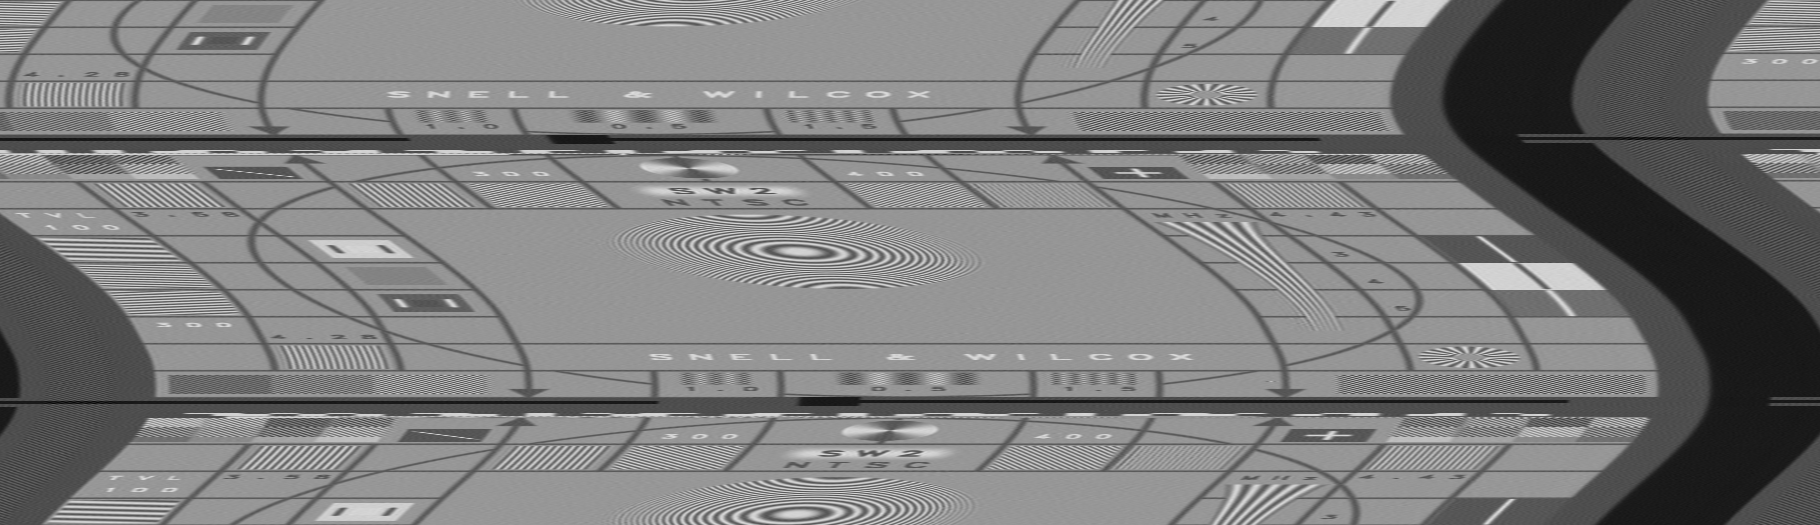

In [74]:
drawdata(data)

In [6]:
# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

def RawToIRE(data):
    return (np.float32(data) / out_scale) + minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

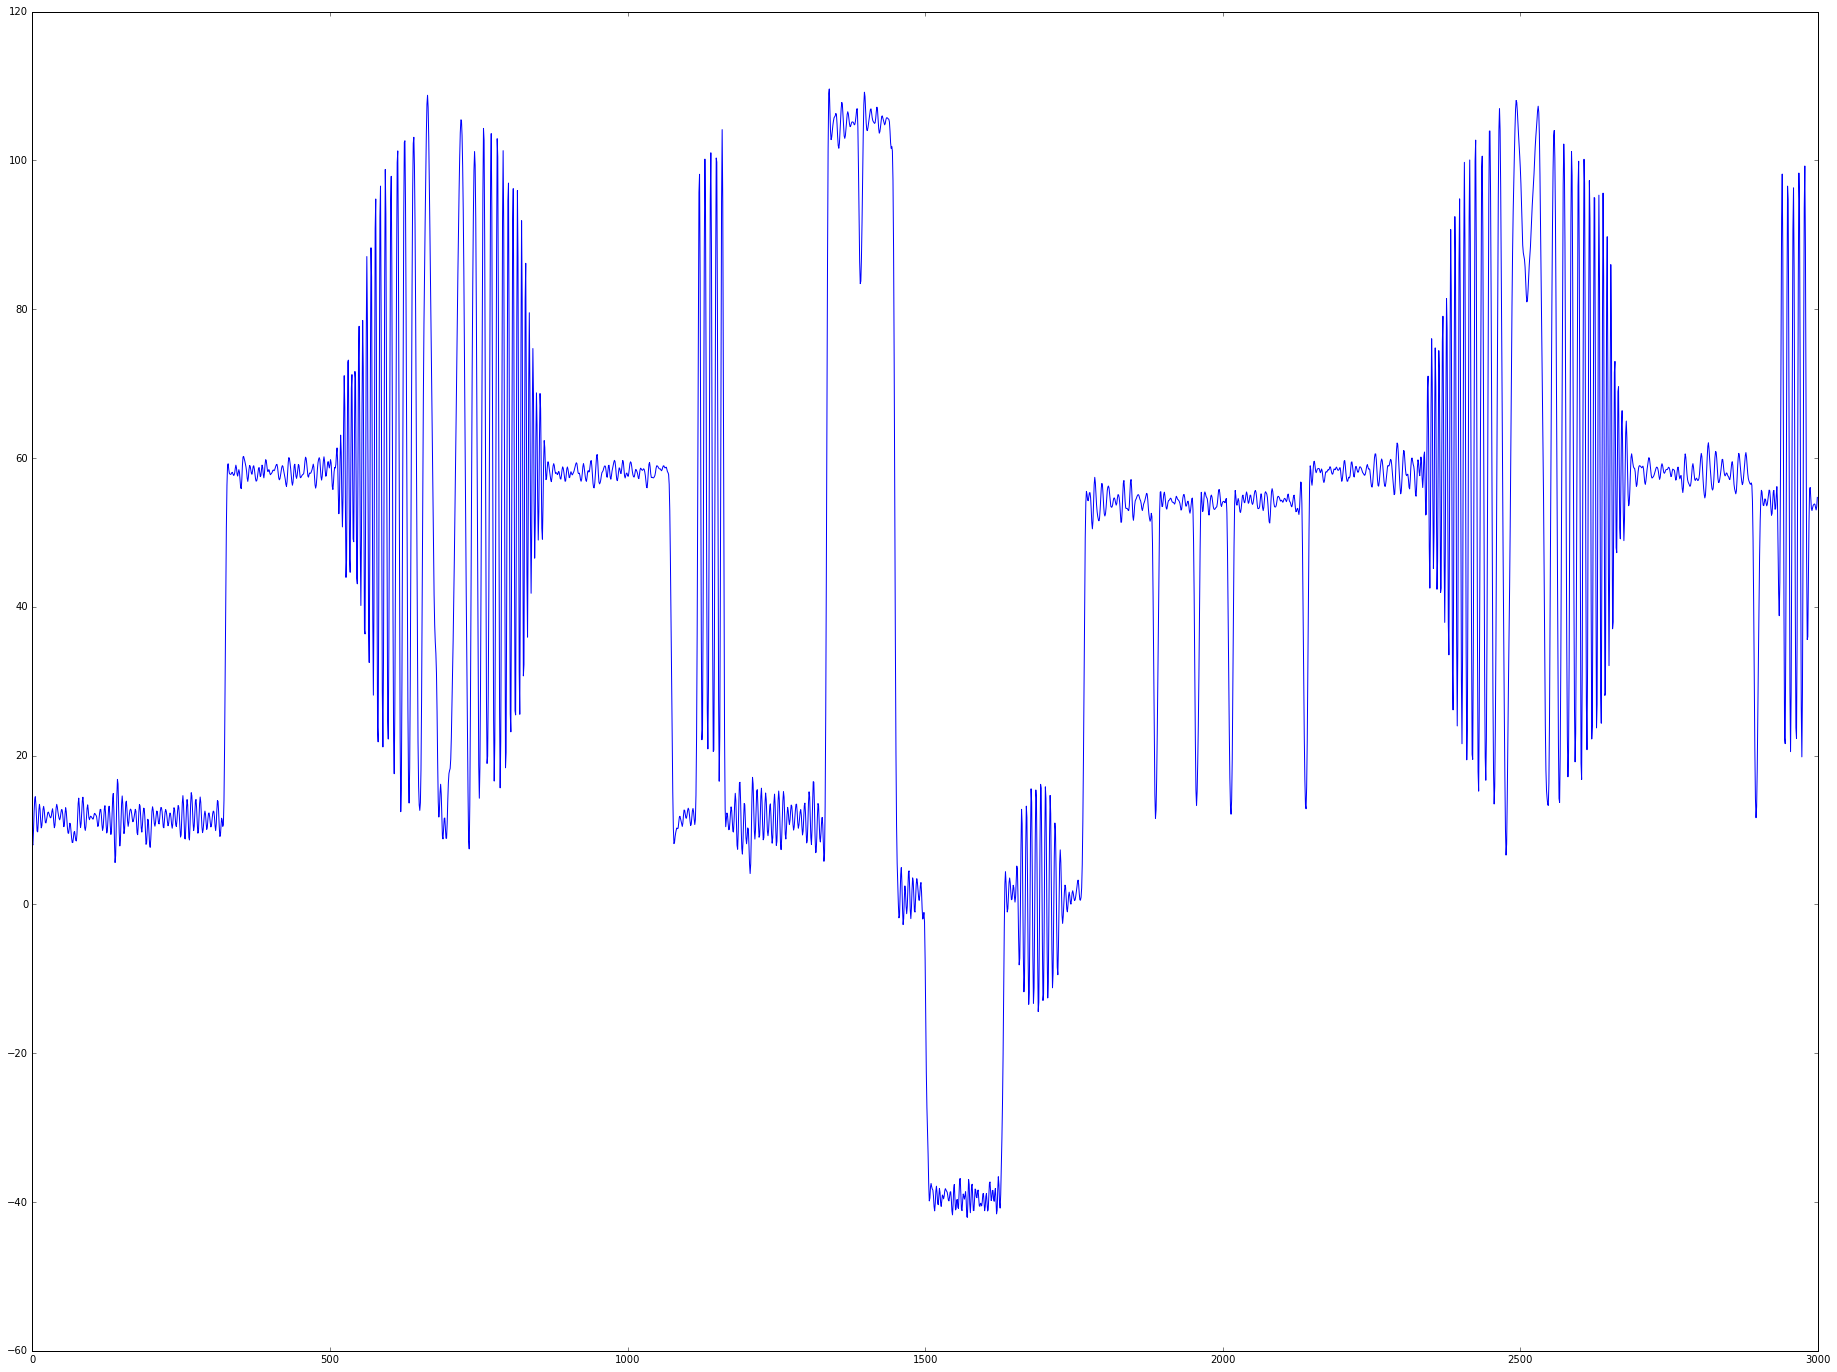

In [7]:
plt.plot(RawToIRE(data[0:3000]))

In [8]:
synctrig = IREToRaw(-21)
sdata = data < synctrig

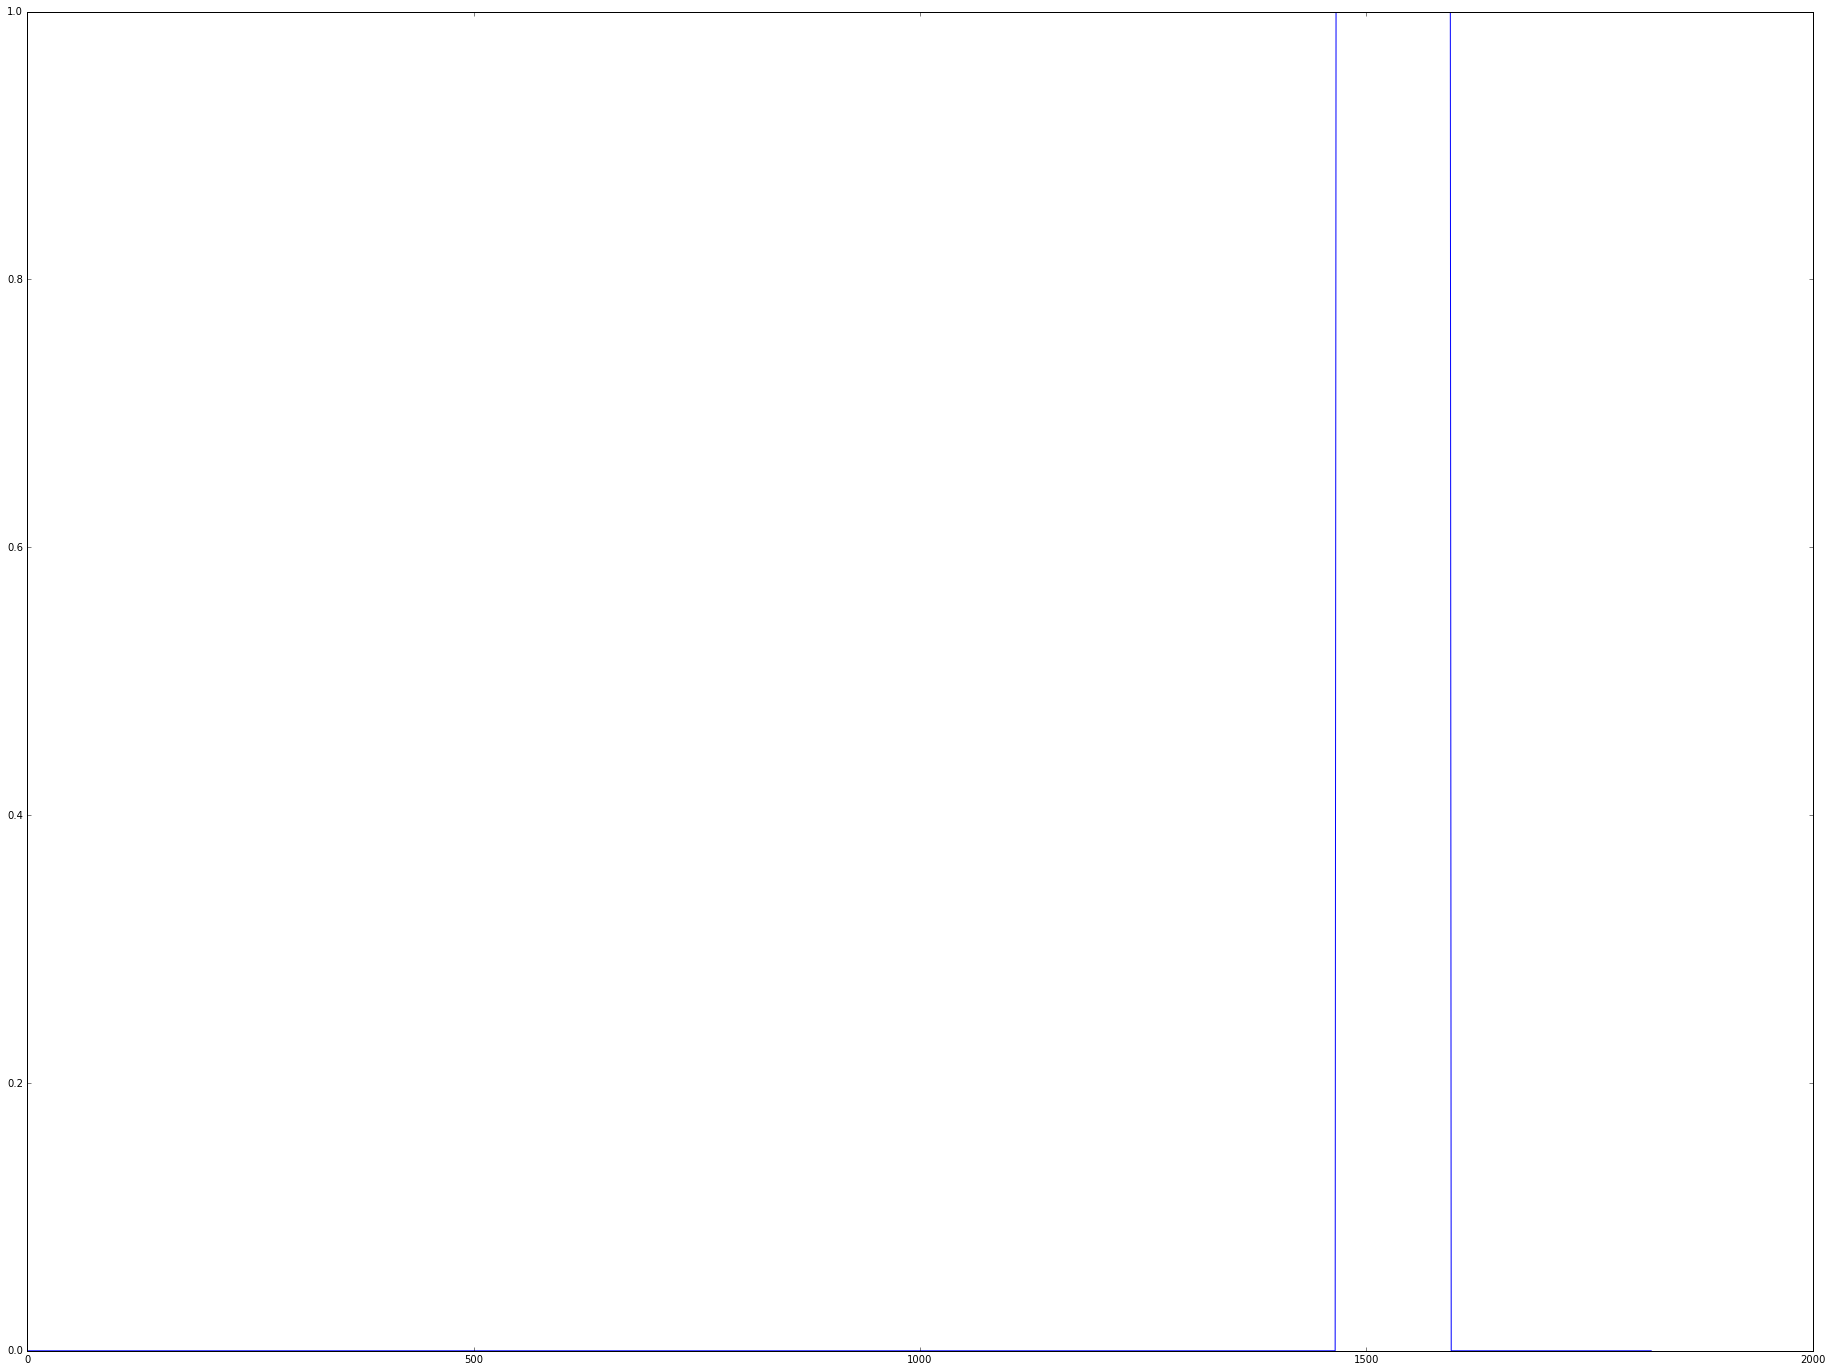

In [9]:
plt.plot(sdata[78260:78260+1820])

In [10]:
FSC = 8
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0

Ncolor = 24
sync_filter = sps.firwin(Ncolor + 1, 0.1 / (freq_mhz / 2.0), window='hamming')

def findpeaks(data):
    dinput = np.diff(data)
    dpeaks = (dinput[:-1] > 0) & (dinput[1:] < 0)
    
#    print(dinput)   
#    print(dpeaks)
    
    return np.where(dpeaks)[0] # - 320
    
f_syncid_b, f_syncid_a = sps.butter(3, 0.002)

def findsyncs(data):
    # Parameters
    synctrig = IREToRaw(-25) # this value should be below any probable colorburst
    hslen = range(FSC * 14, FSC * 17) # typical range of horizontal syncs at synctrig level
    scanlength = int(FSC * (227.5 * 1.25)) # long enough to cover an entire line, but not long enough to see the half-line hsync as well
    
    sdata = data < synctrig
    sfdata = sps.lfilter(f_syncid_b, f_syncid_a, sdata)
    
    peaks = findpeaks(sfdata)
#    print (peaks)
    vsyncs = []
    cvsync = None
    
    # we need to detect the gaps before/after the last full vsync pulse to the prev/next regular hsync,
    # to see which kind of field we're dealing with
    previ = 0
    prevv = 0
    for i in peaks:
        if sfdata[i] > 0.5:
            if previ == None:
                return (1820 * 500), None, None
            
            if len(vsyncs) == 0 or cvsync['gap2'] is not None:
                cvsync = {'hsyncs': [], 'gap1': (i - previ), 'gap2': None}
                vsyncs.append(cvsync)
            
            prevv = i
        elif sfdata[i] > 0.25:
            if cvsync is not None:
                if cvsync['gap2'] is None:
                    cvsync['gap2'] = i - prevv
                    
                cvsync['hsyncs'].append(i - 320)
                
            previ = i
    
    # return a few lines back before the last vsync, so the next read can start correctly
    return vsyncs[-2]['hsyncs'][-3], vsyncs, sfdata

from datetime import datetime
ts = datetime.now()
rlen, peaks, sfdata = findsyncs(data)
print(datetime.now() - ts)

0:00:00.476970


In [11]:
from scipy import interpolate

# This uses numpy's interpolator, which provides very good results
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)


In [113]:
# set up sync color heterodyne table first 
freq = 4.0

bhet = np.empty(4096, dtype=np.complex)
for i in range(0, 4096):
        bhet[i] = complex(np.cos(((i / freq) * 2.0 * np.pi) + (33.0/180.0)), -(np.sin(((i / freq) * 2.0 * np.pi) + (33.0/180.0))))
        bhet[i] = complex(np.cos(((i / freq) * 2.0 * np.pi) + (0.0/180.0)), -(np.sin(((i / freq) * 2.0 * np.pi) + (0.0/180.0))))

color_filter = sps.firwin(17, 0.1 / (freq_mhz / 2), window='hamming')

def burst_detect(data):
        level = 0
        phase = 0

        blen = len(data)
        
#        print(data)        

        dataf = data.astype(np.float32)
        data = dataf - np.mean(dataf)
        
        obhet = np.empty(blen, dtype=np.complex)

        obhet = bhet[0:blen] * data[0:blen]

        obhet_filt = obhet
        
#        print(obhet)
        obhet_filt = sps.lfilter(color_filter, [1.0], obhet)
        obhet_levels = np.fabs(np.absolute(obhet_filt))
        obhet_angles = np.angle(obhet_filt)

        for i in range(0, blen):
#            print(i, data[i], obhet_filt[i], obhet_levels[i], obhet_angles[i])
            if (obhet_levels[i] > level) and (obhet_levels[i] < 10000):
                level = obhet_levels[i]
                phase = obhet_angles[i]

        return [level, phase]
    
def wrap_angle(angle, tgt):
        adjust = tgt - angle
        if (adjust > (np.pi)):
                adjust -= 2 * np.pi
        elif (adjust < (-np.pi)):
                adjust += 2 * np.pi

        return adjust

phasemult = 1.591549430918953e-01 * 8 # this has something to do with pi/radians, forgot what 


31
field : 5
field : 6
field : 7
(477750,)
uint8 (525, 910) (525, 910)


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


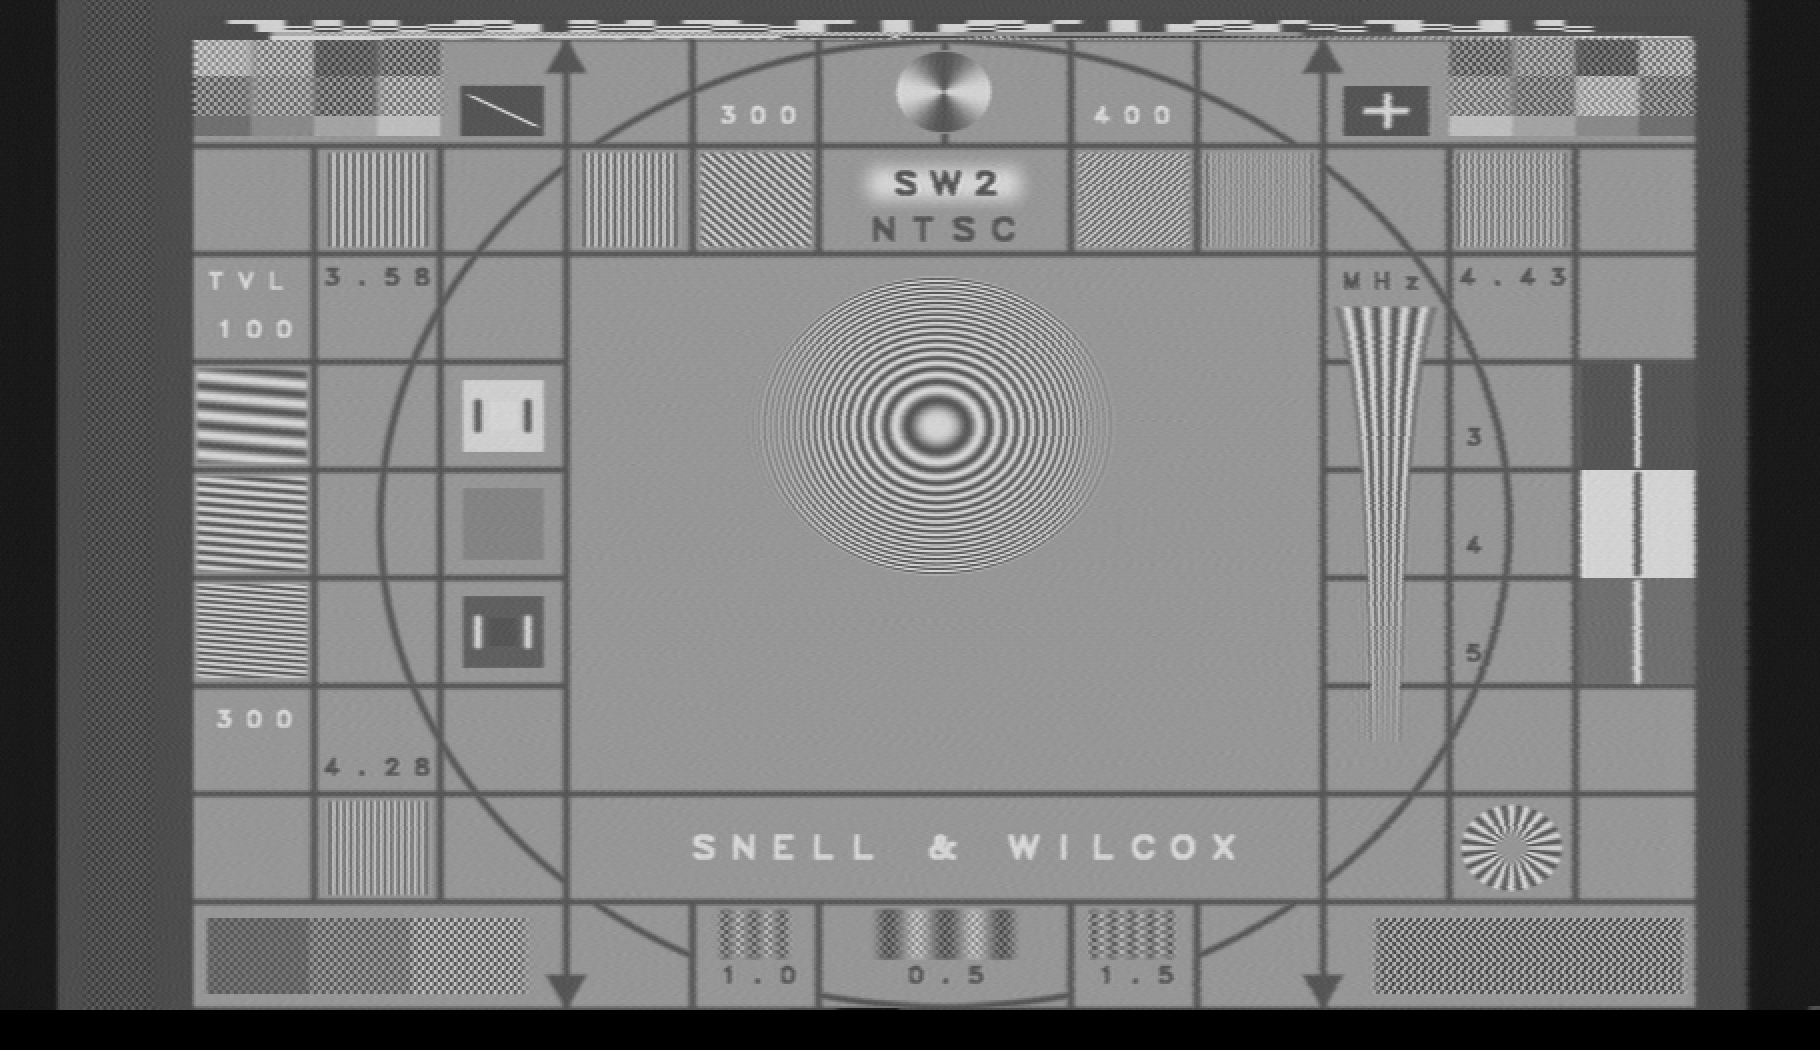

In [129]:
def frameup(data, peaks, sfdata, start = 1000000):
    print(len(peaks))
    
    framebuf = np.zeros(910 * 525, dtype=np.uint16)
    phases = np.zeros(525)
    
    frameno = -1
    for i in range(5, len(peaks)):
        if peaks[i]['hsyncs'][0] < start:
            continue
        
        print("field :", i)
        
        field = peaks[i]
        field['bphase'] = np.zeros(525)
        is_even = (field['gap1'] / float(field['gap2'])) < 1.05
        
        if is_even == 0 and frameno < 0:
            frameno = 0
        
#        print(field['hsyncs'])
        
        if frameno >= 0:
            for i in range(1, len(field['hsyncs'])):
                # compute line #
                l = (i - 1) * 2
                if is_even != 0:
                    l += 1
                
                # -320 is LPF compensation, will vary depending on LPF parameters
                linestart = field['hsyncs'][i]
                try:
                    nextlinestart = (field['hsyncs'][i + 1])
                except:
                    nextlinestart = linestart + 1820 # XXX
 
                gap = float(nextlinestart - linestart) / 1820.0

                for r in range(0, 3):
                    lx = scale(data, linestart, nextlinestart, 910)
                    framebuf[l * 910:((l + 1) * 910)] = lx

#                framebuf[l * 1820:(l + 1) * 1820] = data[linestart:linestart+1820] 

                    phases[l] = burst_detect(lx[32:90])[1]
    
                    ptgt = np.pi if (np.fabs(phases[l]) > 2.25) else 0
        
                    adj = wrap_angle(phases[l], ptgt)
                    linestart += adj
                    nextlinestart += (gap * adj)
                
                #print(l, linestart)
                frame[l] = linestart
                
            if is_even == 1:
                return frame, framebuf, phases
            
frame, framebuf, phases = frameup(data, peaks, sfdata)
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)

In [112]:
print(np.fabs(phases) > 2)
for i in range(0, len(phases)):
    print(i, phases[i])

[ True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  True False False  True
  True False False  True  True False False  True  T

In [47]:
print(b1)
print(b2)
print(b3)
print(b4)

[139.3804149374283, 0.58258705724780502]
[138.50670114856899, -2.5831907128137912]
[116.9388052929651, -2.9240342369696819]
[113.36441416018089, 1.6779767927203437]


In [55]:
peaks[2]

{'bphase': array([-2.48461026, -2.99964046,  0.12688676, -2.99024024,  0.14761274,
        -3.07728848,  0.0716557 , -3.00383901, -0.04211413, -2.56898714,
         1.0794213 , -0.91970719, -1.35681965, -0.36436028, -0.98731787,
        -0.61593453,  1.93761221, -0.15850974,  2.2895044 , -1.00413846,
         1.9663821 , -1.20266325,  2.38365481, -0.99245455,  2.02926341,
        -0.66445052,  2.21905843,  1.91009395,  1.90438038, -0.85907787,
         0.18674988,  3.04768219,  0.41323052, -2.94374421,  0.04113023,
        -2.7262348 ,  0.26616865, -3.08398088, -0.16251278, -1.8811664 ,
         1.99974758,  2.92327104,  2.72961931, -0.11361693, -2.59287264,
         1.21828608, -1.26838862,  2.92807459, -0.40710835, -2.82796202,
         2.92850086, -1.97435815,  1.28478735, -1.07635903,  2.65802679,
         0.28039694,  2.78977833,  1.03679743, -1.34644254,  2.90566121,
         2.69804516, -2.82990101,  2.81605116, -2.83950254,  0.47828494,
        -2.96664036,  0.05895836, -2.8329

In [ ]:
plt.plot(data[peaks[10]['hsyncs'][50]-320:peaks[10]['hsyncs'][51]-130])

In [ ]:
frame[50].hsync

In [ ]:
IREToRaw(-15)

In [ ]:
peaks[10]['hsyncs'][50]

In [ ]:
field

In [ ]:
peaks[10]['hsyncs'][51]-peaks[10]['hsyncs'][50]

In [96]:
l1 = framebuf[57 * 910:58 * 910]
l2 = framebuf[58 * 910:59 * 910]

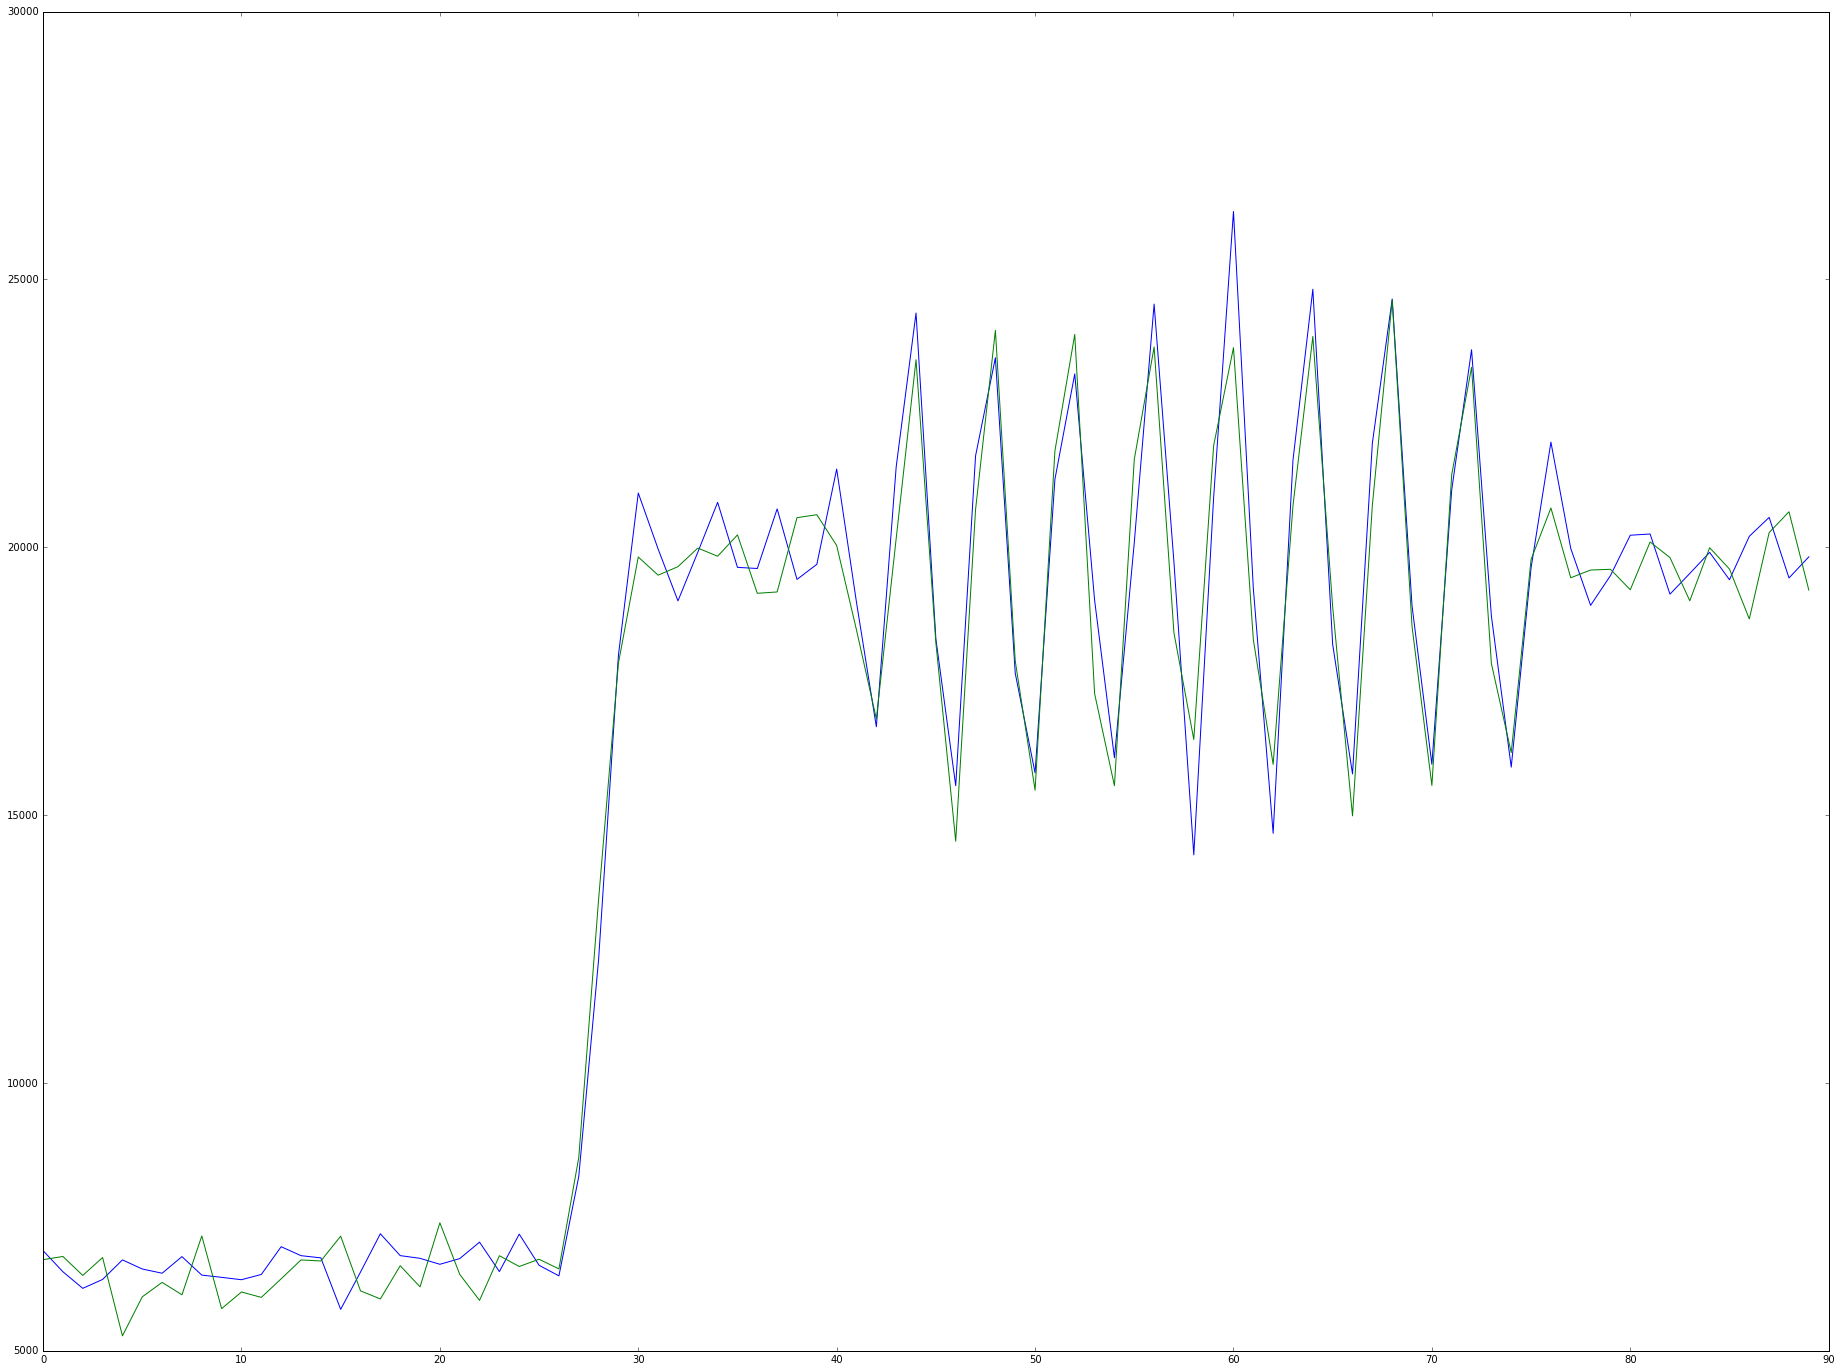

In [108]:
plt.plot(l1[0:90])
plt.plot(l2[0:90])

In [ ]:
burst_detect(data[l2+85:l2+155])

In [ ]:
burst_detect(data[l1+85:l1+155])

In [ ]:
l2

In [ ]:
data[l2+85:l2+155]

In [92]:
l1

array([], dtype=uint16)

In [124]:
l = 52
ptgt = np.pi if (np.fabs(phases[l]) > 2.25) else 0
print(phases[l], ptgt, wrap_angle(phases[l], ptgt))

-2.70173460324 3.141592653589793 -0.439858050353


In [117]:
phases[50]

-0.16142001532111358